# Pylops - multi-process linear operators

### Author: M.Ravasi

In this notebook we will experiment with multiprocess/multithread to speed up embarassingly parallel operators like VStack, HStack, BlockDiag

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time

import pylops
import multiprocessing as mp

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.basicoperators             import *
from pylops.waveeqprocessing.wavedecomposition import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [27]:
def scalability_test(Op, x, workerexp=2):
    workers=list()
    compute_times=list()
    speedup=list()
    for i in range(workerexp):
        workers.append(2 ** i)
        print('Working with %d workers...' % workers[-1])
        # update number of workers
        Op.nproc = workers[i]
        print(Op.pool)
        # run forward
        ptime = time.time()
        result = Op * x
        ptime = time.time() - ptime
        compute_times.append(ptime)
        speedup.append(compute_times[0]/ptime)
    Op.pool.close()
    return workers, compute_times, speedup

## Simple example

In [4]:
def fun(G, x, i):
    print('Starting:', mp.current_process().name) 
    time.sleep(10)
    return np.dot(G, x)

In [5]:
nprocs = 4 #mp.cpu_count()
print("%d worker available" %nprocs)

# let's create a pool of workers
pool = mp.Pool(processes=nprocs)

t0 = time.time()
n = 5000
G = np.random.normal(0., 1., (n, n))
results = pool.starmap(fun, [(G, np.random.normal(0., 1., n), i) for i in range(nprocs*4)])
print('Elapsed time (mins): ', (time.time()- t0) / 60.)

4 worker available
Starting: ForkPoolWorker-1
Starting: ForkPoolWorker-2
Starting: ForkPoolWorker-3
Starting: ForkPoolWorker-4
Starting: ForkPoolWorker-1
Starting: ForkPoolWorker-2
Starting: ForkPoolWorker-3
Starting: ForkPoolWorker-4
Starting: ForkPoolWorker-1
Starting: ForkPoolWorker-2
Starting: ForkPoolWorker-3
Starting: ForkPoolWorker-4
Starting: ForkPoolWorker-1
Starting: ForkPoolWorker-2
Starting: ForkPoolWorker-3
Starting: ForkPoolWorker-4
Elapsed time (mins):  0.7383219401041666


## HStack with matrix mult

Overhead seems to kill benefit

In [6]:
nprocs = 4 #mp.cpu_count()
print("%d worker available" %nprocs)

n = 5000
N = nprocs * 4
G = np.random.normal(0., 1., (n,n))
x = np.ones(n*N)

Gop = MatrixMult(G)
Sop = HStack([G]*N)
S1op = HStack([G]*N, nproc=nprocs)

4 worker available
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting: ForkPoolWorker-5
Starting: ForkPoolWorker-6
Starting: ForkPoolWorker-7
Starting: ForkPoolWorker-8
Starting:

In [7]:
y = Sop * x 
y1 = S1op * x

dottest(Sop, verb=True)
dottest(S1op, verb=True)
print(np.allclose(y, y1))

Dot test passed, v^T(Opu)=-26710.473916 - u^T(Op^Tv)=-26710.473916
Dot test passed, v^T(Opu)=-14349.405047 - u^T(Op^Tv)=-14349.405047
True


In [8]:
t0 = time.time()
Sop * x
print(time.time()-t0)

0.23723864555358887


In [9]:
t0 = time.time()
S1op * x
print(time.time()-t0)

6.90562891960144


## BlockDiag with matrix mult

Overhead seems to kill benefit

In [10]:
Sop = BlockDiag([G]*N, nproc=1)
print(Sop.pool)
Sop.nproc = 2
print(Sop.pool)
Sop.nproc = 4
print(Sop.pool)

None
<multiprocessing.pool.Pool state=RUN pool_size=2>
<multiprocessing.pool.Pool state=RUN pool_size=4>


In [11]:
workers, compute_times, speedup = scalability_test(Sop, np.ones(N*n), workerexp=4)

Working with 1 workers...
Working with 2 workers...
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-15
Starting: ForkPoolWorker-16
Starting: ForkPoolWorker-16
Working with 4 workers...
Starting: ForkPoolWorker-17
Starting: ForkPoolWorker-18
Starting: ForkPoolWorker-19
Starting: ForkPoolWorker-20
Starting: ForkPoolWorker-17
Starting: ForkPoolWorker-18
Starting: ForkPoolWorker-19
Starting: ForkPoolWorker-20
Starting: ForkPoolWorker-17
Starting: ForkPoolWorker-18
Starting: ForkPoolWorker-19
Starting: ForkPoolWorker-20
Starting: ForkPoolWorker-17
Starting: ForkPoolWorker-18
Starting: ForkPoolWorker-19
Starting: ForkPoolWorker-20
Working with 8 workers...


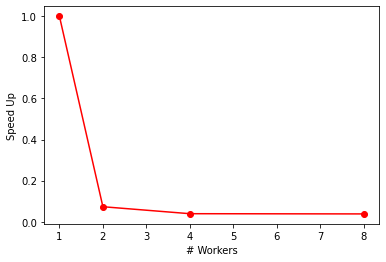

In [12]:
plt.plot(workers,speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');

## PressureToVelocity
Repeat ns times the same operation with ffts

In [13]:
nprocs = 4 #mp.cpu_count()-2
print("%d worker available" %nprocs)

nt, nr, ns = 1024, 512, 200
nfftk, nfftf = 512, 1024
PtoVop = PressureToVelocity(nt, nr, 1., 1.,
                            1000, 2000,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False, dtype='complex128')           
PtoVop1 = BlockDiag([PtoVop]*ns)
PtoVop2 = BlockDiag([PtoVop]*ns, nproc=nprocs)

PtoVop1, PtoVop2

4 worker available


/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:106: RuntimeWarning: divide by zero encountered in true_divide
  OBL = Kz / (rho * np.abs(F))
/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:106: RuntimeWarning: invalid value encountered in true_divide
  OBL = Kz / (rho * np.abs(F))


(<104857600x104857600 BlockDiag with dtype=complex128>,
 <104857600x104857600 BlockDiag with dtype=complex128>)

In [14]:
y = PtoVop1 * np.ones(104857600)
y1 = PtoVop2 * np.ones(104857600)
np.allclose(y, y1)

array([8.24906487e-24+0.j, 8.24906487e-24+0.j, 8.24906487e-24+0.j, ...,
       8.24906487e-24+0.j, 8.24906487e-24+0.j, 8.24906487e-24+0.j])

In [17]:
%timeit -n1 -r2 PtoVop1 * np.ones(104857600)

8.79 s ± 19.1 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [18]:
%timeit -n1 -r2 PtoVop2 * np.ones(104857600)

5.38 s ± 95.1 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [28]:
workers, compute_times, speedup = scalability_test(PtoVop1, np.ones(104857600), workerexp=4)

Working with 1 workers...
<multiprocessing.pool.Pool state=CLOSE pool_size=4>
Working with 2 workers...
<multiprocessing.pool.Pool state=RUN pool_size=2>
Working with 4 workers...
<multiprocessing.pool.Pool state=RUN pool_size=4>
Working with 8 workers...
<multiprocessing.pool.Pool state=RUN pool_size=8>


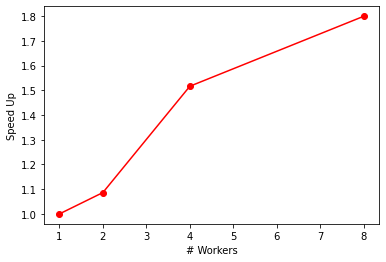

In [29]:
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');

Working with 1 workers...
Working with 2 workers...
Working with 4 workers...
Working with 8 workers...
Working with 1 workers...
Working with 2 workers...
Working with 4 workers...
Working with 8 workers...


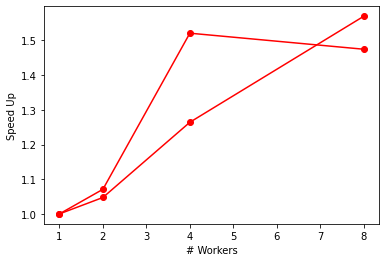

In [32]:
from pylops.utils.multiproc import scalability_test as stest

workers = [1, 2, 4, 8]
compute_times, speedup = stest(PtoVop1, np.ones(PtoVop1.shape[1]), workers=workers, forward=True)
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers')
plt.ylabel('Speed Up')

compute_times, speedup = stest(PtoVop1, np.ones(PtoVop1.shape[0]), workers=workers, forward=False)
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');